In [44]:
#!pip install networkx --user
import numpy as np
import networkx as nx
print("Networkx version: {}".format(nx.__version__))
from time import time
import matplotlib.pyplot as plt
import random
import seaborn as sns
sns.set()

import theano
THEANO_FLAGS='device=cuda,floatX=float32'
theano.config.floatX = 'float32'
%matplotlib inline

Networkx version: 2.3


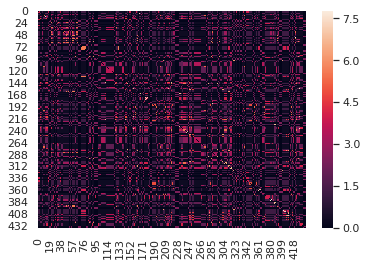

In [36]:
G = nx.read_edgelist("data/resnik.txt", delimiter='\t' , nodetype=str,  data=(('weight',float),))
A = nx.adjacency_matrix(G)
ax = sns.heatmap(A.todense())

In [45]:
import pymc3 as pm
import theano.tensor as tt

def make_pymc3_sbm(Gs, k, labels, directed=False, selfloops=False):
    # input can be a single graph or a list of graphs
    if isinstance(Gs, nx.Graph):
        Gs = [Gs]
    n = len(Gs[0])
    # whether to include the diagonal or not
    if selfloops:
        triu_indices = np.triu_indices(n, k=1)
    else:
        triu_indices = np.triu_indices(n)
    # convert to adjacency matrix
    # if graph is undirected, we just need the upper triangular part
    if directed:
        A_obs = np.array([nx.to_numpy_array(G) for G in Gs]).astype('float32')
    else:
        A_obs = np.array([nx.to_numpy_array(G)[triu_indices] for G in Gs]).astype('float32')

    model = pm.Model()
    with model:
        #pi = pm.Dirichlet('pi', a=np.ones(k), shape=(k,))
        z = labels #pm.Categorical('z', p=pi, shape=(n,))
        eta = pm.Normal('eta', mu=10, sd = 1, shape=(k, k)).astype('float32')
        # parameters to sample the adjacency matrix
        # p[i, j] = eta[z[i], z[j]] is the parameter corresponding to A[i, j]
        p = eta[(z.reshape((n, 1)), z.reshape((1, n)))].astype('float32')
        if not selfloops:
            tt.set_subtensor(p[np.diag_indices(n)], 0.).astype('float32')
        if not directed:
            p = eta[(z.reshape((n, 1)), z.reshape((1, n)))][triu_indices].astype('float32')
        W = pm.Normal('W', mu=p, sd=1, shape=A_obs[0].shape, observed=A_obs).astype('float32')
    return model

In [49]:
k = 3
labels = np.full(shape=len(G),fill_value=0)
labels[::3] = 1
model = make_pymc3_sbm(G, k, labels)
with model as m1:
    #start = pm.find_MAP()
    #trace = pm.sample(50000, start=start, progressbar=True)
    trace1 = pm.sample(500, tune = 500)

/home/jovyan/.local/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/jovyan/.local/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 3000/3000 [47:47<00:00,  4.92draws/s]
The acceptanc

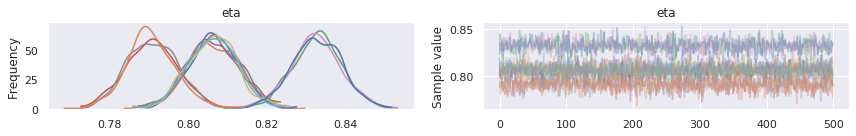

In [17]:
pm.traceplot(trace1);

In [18]:
pm.summary(trace1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
eta__0_0,0.806526,0.006289,0.000156,0.795399,0.819532,1509.904629,0.999666
eta__0_1,0.832539,0.006468,0.000164,0.820724,0.846360,1588.340047,1.000041
eta__1_0,0.806286,0.006623,0.000130,0.792825,0.819012,1971.517655,0.999522
eta__1_1,0.790701,0.006497,0.000165,0.777662,0.803034,1713.584897,0.999712


In [42]:
from pymc3 import Model, NUTS, sample
from pymc3.distributions import DensityDist
import pymc3 as pm
import theano
import numpy as np

theano.config.floatX = 'float32'
theano.config.compute_test_value = 'raise'
theano.config.exception_verbosity= 'high'
with model as denoising_model:
#     theano.config.compute_test_value = 'off'

    x = DensityDist('x',
            logp= lambda value: -(value**2).sum(),
            shape=(1, 1, 10, 10),
            testval=np.random.randn(1,1,10,10).astype('float32'),
            dtype='float32',
        )

    sampler = pm.Metropolis()
    trace = sample(100, sampler)

Only 100 samples in chain.
Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>Metropolis: [x]
>Metropolis: [eta]
Sampling 3 chains: 100%|██████████| 1800/1800 [00:02<00:00, 608.28draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


In [48]:
from theano import function, config, shared, tensor
import numpy
import time

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], tensor.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in range(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, tensor.Elemwise) and
              ('Gpu' not in type(x.op).__name__)
              for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')

[Elemwise{exp,no_inplace}(<TensorType(float32, vector)>)]
Looping 1000 times took 4.254945 seconds
Result is [1.2317803 1.6187934 1.5227807 ... 2.2077181 2.2996776 1.6232328]
Used the cpu
